<a href="https://colab.research.google.com/github/casualcomputer/statistics_applications/blob/main/policy_effect_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Difference-in-Difference estimation



**Basic equation:** Registrations$_{i}$ = $\beta_0$+ $\beta_1$* Indicator(is quebec)+ $\beta_2$* Indicator(after policy in effect)+ $\beta_3$* Indicator(is quebec)* Indicator(after policy in effect)

1. Before policy in effect:
  
  * quebec: $\beta_0$ + $\beta_1$
  * non-quebec provinces: $\beta_0$    
  * Here, the difference **provincial_delta_pre_policy** (Quebec vs. non-Quebec) is indeed represented by $\beta_1$, indicating how much higher or lower the registrations were in Quebec compared to non-Quebec before the policy.


2. After policy in effect:

  * quebec: $\beta_0$ + $\beta_1$ +$\beta_2$ +$\beta_3$
  * non-quebec provinces: $\beta_0$ +$\beta_2$
  * In this scenario, the **difference provincial_delta_after_policy** (Quebec vs. non-Quebec) becomes $\beta_1 + \beta_3$. This measures the combined effect of the inherent differences between Quebec and non-Quebec plus the additional impact of the policy in Quebec.

3. Interpretation of Coefficients:
* $\beta_1$ tells you how different Quebec was from non-Quebec in terms of vehicle registrations before the policy.
* $\beta_2$ tells you the effect of the policy across the board (assuming it applies in some form to all provinces).
* $\beta_3$ provides the incremental effect of the policy in Quebec, adjusting for the general policy effect.

Important things to consider:

1. policy may apply to different products (e.g. vehicles with different watts ratings) at different rebate levels

2. we are making the following statistical assumptions:

*   *consistency:* non-quebec group never received the policy rebates, quebec only received the rebate after the policy was put in effect.
*   *arrow-of-time:* future policy doesn't affect past outcomes, i.e., the cause (policy implementation) occurs before its effects (changes in sales).
*   *parallel trends:* in the absence of the rebate policy, Quebec and non-Quebec provinces would have experienced similar trends in sales over time



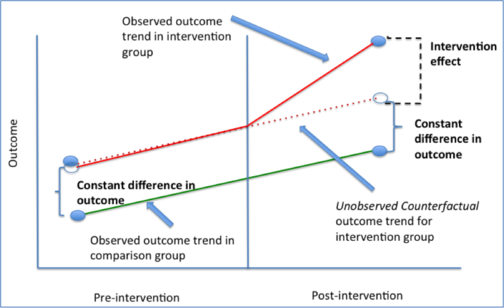

More literature: https://diff.healthpolicydatascience.org/

Picture: https://learncuriously.wordpress.com/2021/06/18/pre-post-analysis/

# Data Cleaning

In [2]:
install.packages("lubridate")
#install.packages("reactable")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# Load the readr library
library(readr)

# Load the CSV data directly from the URL using read_csv
data <- read_csv("https://raw.githubusercontent.com/casualcomputer/statistics_applications/main/2010002401_databaseLoadingData.csv")

# View the first few rows of the dataframe to check the data
head(data)

Rows: 1450 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): REF_DATE, GEO, DGUID, Fuel type, Vehicle type, Statistics, UOM, SC...
dbl  (4): UOM_ID, SCALAR_ID, VALUE, DECIMALS
lgl  (2): SYMBOL, TERMINATED

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>
2017-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-07,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-10,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0


In [4]:
# Selecting columns by their indices
selected_data <- data[, c(1, 2, 4, 5,13)]

# Clean dates
library(lubridate)
selected_data$REF_DATE <- lubridate::as_date(ym(selected_data$REF_DATE))

# View the first few rows to confirm the change
head(selected_data)

# show unique values
unique(selected_data$GEO) #'Battery electric'
unique(selected_data$`Fuel type`) #'Battery electric'
unique(selected_data$`Vehicle type`) #'Total, vehicle type''Passenger cars''Pickup trucks''Multi-purpose vehicles''Vans'



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




REF_DATE,GEO,Fuel type,Vehicle type,VALUE
<date>,<chr>,<chr>,<chr>,<dbl>
2017-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-07-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-10-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA


[1] "Newfoundland and Labrador"           
 [2] "Prince Edward Island"                
 [3] "Nova Scotia"                         
 [4] "New Brunswick"                       
 [5] "Quebec"                              
 [6] "Ontario"                             
 [7] "Manitoba"                            
 [8] "Saskatchewan"                        
 [9] "Alberta"                             
[10] "British Columbia and the Territories"

[1] "Battery electric"

[1] "Total, vehicle type"    "Passenger cars"         "Pickup trucks"         
[4] "Multi-purpose vehicles" "Vans"

In [5]:
# Create indicators for DID setup
library(dplyr)
library(stringr)
df <- selected_data %>%
  mutate(is_quebec = case_when(
    str_detect(GEO, "Quebec") ~ 1,  # Detects 'Quebec' in the 'region' column
    TRUE ~ 0  # Default case, assigns 0 if not 'Quebec'
  ),
  after_policy = case_when(
    REF_DATE>=as.Date("2023-04-18") ~ 1,
    TRUE ~ 0
  ),
  ref_year = year(REF_DATE)
) %>%
  filter(VALUE!="NA")
names(df) = c("ref_date","province","fuel_type","vehicle_type","registrations","is_quebec","after_policy","ref_year")
head(df)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,0,0,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,0,0,2018


In [6]:
# Assuming df is your dataframe and it includes 'province', 'vehicle_type', and 'ref_year' columns
aggregated_df = df %>%
   filter(vehicle_type=="Total, vehicle type")
head(aggregated_df)


ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,0,0,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,0,0,2018


# Data visualization: Quebec vs. non-Quebec registrations before/after policy rebates

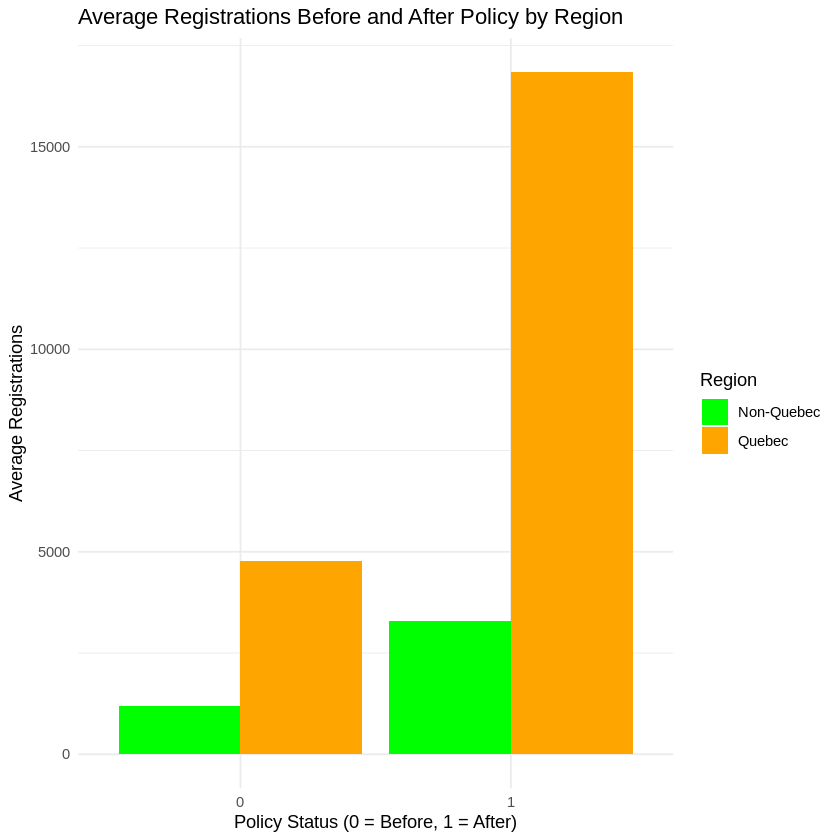

In [7]:
library(ggplot2)
# Create a grouped bar chart to compare sales before and after policy by region
ggplot(aggregated_df, aes(x = as.factor(after_policy), y = registrations, fill = as.factor(is_quebec))) +
  geom_bar(stat = "summary", fun = "mean", position = position_dodge()) +
  labs(title = "Average Registrations Before and After Policy by Region",
       x = "Policy Status (0 = Before, 1 = After)",
       y = "Average Registrations",
       fill = "Region") +
  scale_fill_manual(values = c("green", "orange"),
                    labels = c("Non-Quebec", "Quebec")) +
  theme_minimal()


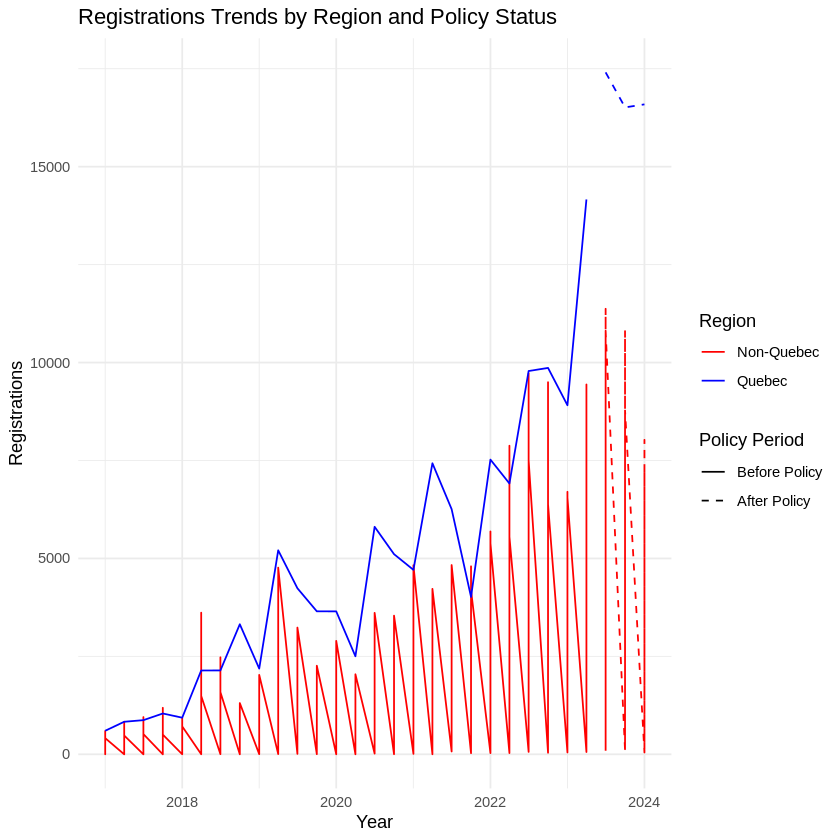

In [8]:
library(ggplot2)

# Convert is_quebec and after_policy to factors if they're not already
aggregated_df$is_quebec <- factor(aggregated_df$is_quebec, levels = c(0, 1), labels = c("Non-Quebec", "Quebec"))
aggregated_df$after_policy <- factor(aggregated_df$after_policy, levels = c(0, 1), labels = c("Before Policy", "After Policy"))

# Assuming aggregated_df is correctly set up and the necessary libraries are loaded
ggplot(aggregated_df, aes(x = ref_date, y = registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +  # Use line geometry to represent data trends over time
  labs(title = "Registrations Trends by Region and Policy Status",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red","blue")) +  # Ensure colors are correctly assigned to factor levels
  scale_linetype_manual(values = c("solid",  "dashed")) +  # Ensure line types are correctly assigned
  theme_minimal()  # Use a minimalistic theme for a clean look


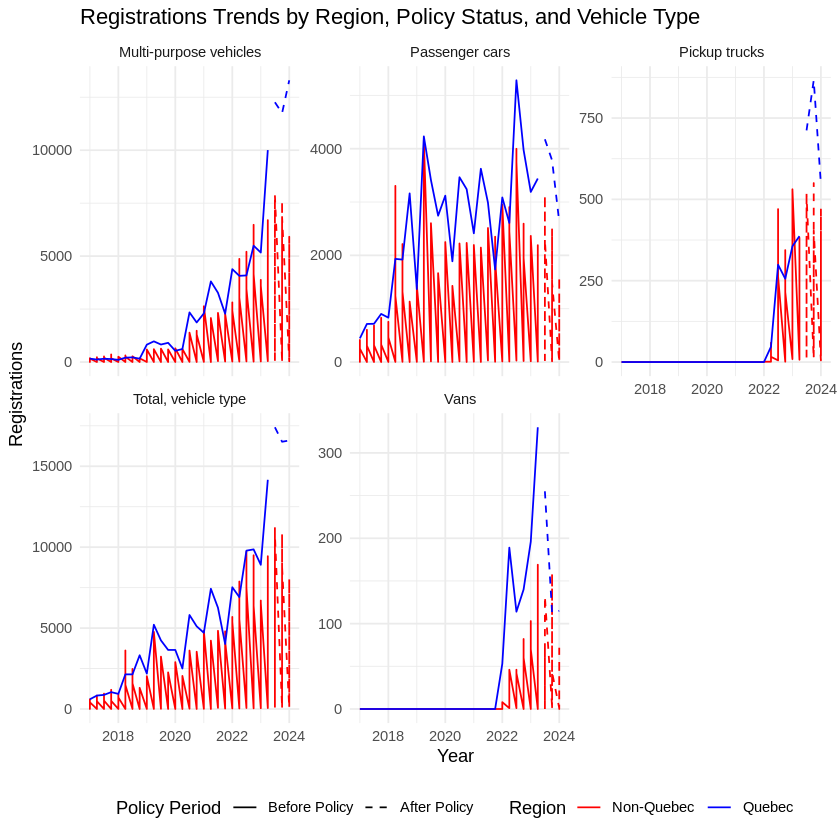

In [9]:
# create factors for visualization by facets
df$is_quebec <- factor(df$is_quebec, levels = c(0, 1), labels = c("Non-Quebec", "Quebec"))
df$after_policy <- factor(df$after_policy, levels = c(0, 1), labels = c("Before Policy", "After Policy"))

# Create the plot with facets for each vehicle type
ggplot(df, aes(x = ref_date, y = registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +  # Use line geometry to show trends
  facet_wrap(~ vehicle_type, scales = "free_y") +  # Create separate plots for each vehicle type
  labs(title = "Registrations Trends by Region, Policy Status, and Vehicle Type",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red", "blue")) +  # Customize colors for clarity
  scale_linetype_manual(values = c("solid", "dashed")) +  # Customize line types for before and after policy
  theme_minimal() +  # Use a minimal theme for a clean look
  theme(legend.position = "bottom")  # Position the legend at the bottom for better accessibility


# Basic DID model: modeling totoal registrations by province

In [17]:
# Assuming `df` is your DataFrame with `sales` as the outcome, `year` for time, `is_quebec` as a group indicator, and `after_policy` as the post-policy period indicator

# Basic DiD model
basic_did <- lm(registrations ~ is_quebec * after_policy, data = aggregated_df) #beta3: 3982.86
summary(basic_did)

# Basic DiD model loged
log_basic_did <- lm(log(registrations+1) ~ is_quebec * after_policy, data = aggregated_df) #beta3: 3982.86
summary(log_basic_did)


Call:
lm(formula = registrations ~ is_quebec * after_policy, data = aggregated_df)

Residuals:
   Min     1Q Median     3Q    Max 
 -4160  -1180  -1113    424   9401 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                                1185.3      212.6   5.575 8.00e-08
is_quebecQuebec                            3576.2      562.5   6.357 1.38e-09
after_policyAfter Policy                   2118.0      661.1   3.204  0.00158
is_quebecQuebec:after_policyAfter Policy   9957.1     1749.0   5.693 4.43e-08
                                            
(Intercept)                              ***
is_quebecQuebec                          ***
after_policyAfter Policy                 ** 
is_quebecQuebec:after_policyAfter Policy ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2656 on 199 degrees of freedom
Multiple R-squared:  0.4141,	Adjusted R-squared:  0.4053 
F-statistic: 46.89 o


Call:
lm(formula = log(registrations + 1) ~ is_quebec * after_policy, 
    data = aggregated_df)

Residuals:
   Min     1Q Median     3Q    Max 
-4.650 -1.575 -0.293  2.085  4.532 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                                4.6497     0.1921  24.209  < 2e-16
is_quebecQuebec                            3.5191     0.5082   6.925 5.88e-11
after_policyAfter Policy                   1.8166     0.5972   3.042  0.00267
is_quebecQuebec:after_policyAfter Policy  -0.2544     1.5800  -0.161  0.87227
                                            
(Intercept)                              ***
is_quebecQuebec                          ***
after_policyAfter Policy                 ** 
is_quebecQuebec:after_policyAfter Policy    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.399 on 199 degrees of freedom
Multiple R-squared:  0.2407,	Adjusted R-squared:  0.2293 
F-sta

# Linear model's assumptions (Basic DID model)

In [11]:
install.packages("lmtest")
install.packages("regclass")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘Rcpp’, ‘RcppEigen’, ‘glmnet’, ‘grpreg’, ‘pls’, ‘bestglm’, ‘leaps’, ‘VGAM’, ‘randomForest’, ‘rpart.plot’


Warning message in install.packages("regclass"):
“installation of package ‘VGAM’ had non-zero exit status”
Warning message in install.packages("regclass"):
“installation of package ‘rpart.plot’ had non-zero exit status”
Warning message in install.packages("regclass"):
“installation of package ‘RcppEigen’ had non-zero exit status”
Warning message in install.packages("regclass"):
“installation of package ‘glmnet’ had non-zero exit status”
Warning message in install.packages("regclass"):
“installation of package ‘bestglm’ had non-zero exit status”
Warning message in install.packages("regclass"):
“installation of packa

In [14]:
get_lm_assumptions <- function(lm_model){

  print("\nPlot Residuals vs. Predicted Values: This helps to identify any non-linear patterns. \nIf the model is appropriate, the residuals should appear as a random scatter.")
  plot(predict(lm_model), residuals(lm_model), main = "Residuals vs. Predicted", xlab = "Predicted", ylab = "Residuals")
  abline(h = 0, col = "red")

  print("\nHistogram of residuals")
  hist(residuals(lm_model), breaks = 30, main = "Histogram of Residuals", xlab = "Residuals") #highly skewed

  print("\nQQ plot of residuals")
  qqnorm(residuals(lm_model))
  qqline(residuals(lm_model), col = "red") #normal should look like this

  print("\nResiduals vs. Fitted Plot:")
  print("Look for a funnel shape or a pattern suggesting changing variance.")
  plot(predict(lm_model), residuals(lm_model), main = "Residuals vs. Fitted", xlab = "Fitted", ylab = "Residuals")
  abline(h = 0, col = "red")

  print("\nIndependence of Residuals:\n There should be no correlation between consecutive residuals in the data (important in time series data or panel data).")
  print("Durbin-Watson Test: Tests for autocorrelation of residuals. A Durbin-Watson statistic close to 2 suggests no autocorrelation.")
  library(lmtest)
  dw_test_result <- dwtest(lm_model)
  print(dw_test_result)


  library(regclass)
  print("No Multicollinearity: Predictors should not be too highly correlated.")
  print("Variance Inflation Factor (VIF): VIF values greater than 10 (some sources say 5) suggest serious multicollinearity.")
  vif(lm_model)  # Check for multicollinearity

  print("\nNo High-leverage or Influential Points: These can disproportionately influence the fit of the model.")
  print("\nCook’s Distance: Identify observations that have a large influence on the regression coefficients.")
  plot(cooks.distance(lm_model), type = "h", main = "Cook's Distance")
}

[1] "\nPlot Residuals vs. Predicted Values: This helps to identify any non-linear patterns. \nIf the model is appropriate, the residuals should appear as a random scatter."
[1] "\nHistogram of residuals"


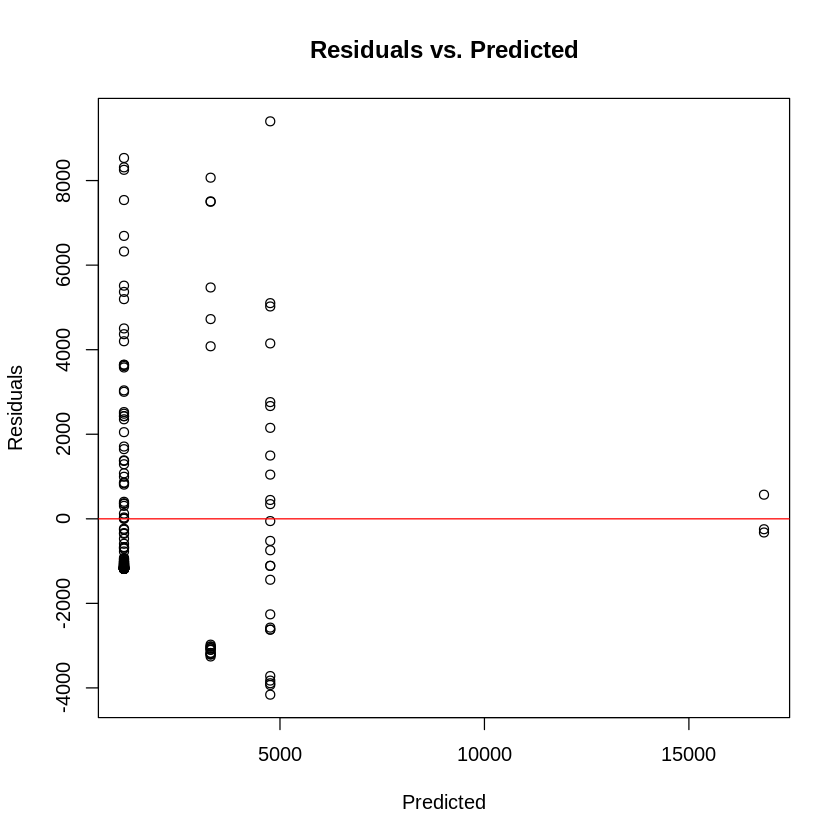

[1] "\nQQ plot of residuals"


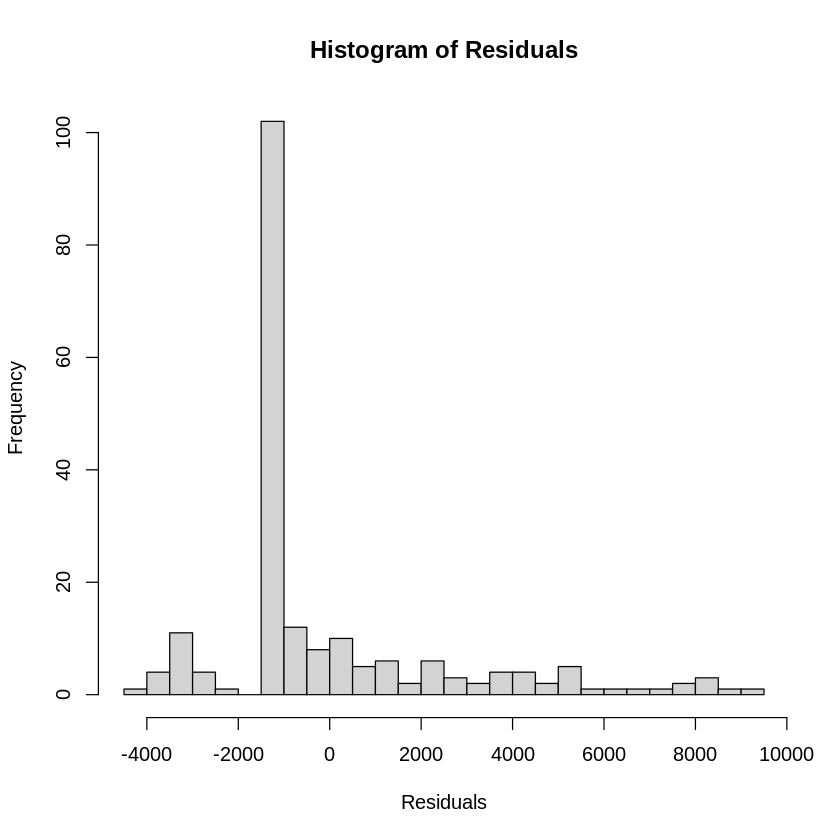

[1] "\nResiduals vs. Fitted Plot:"
[1] "Look for a funnel shape or a pattern suggesting changing variance."
[1] "\nIndependence of Residuals:\n There should be no correlation between consecutive residuals in the data (important in time series data or panel data)."
[1] "Durbin-Watson Test: Tests for autocorrelation of residuals. A Durbin-Watson statistic close to 2 suggests no autocorrelation."

	Durbin-Watson test

data:  lm_model
DW = 0.22914, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0



ERROR: Error in library(regclass): there is no package called ‘regclass’


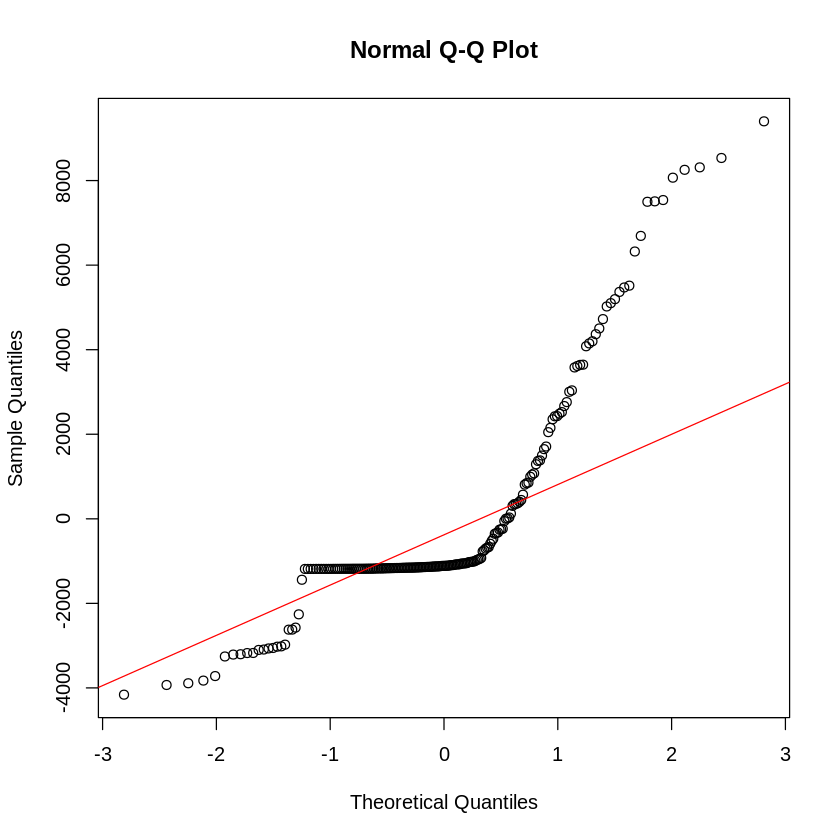

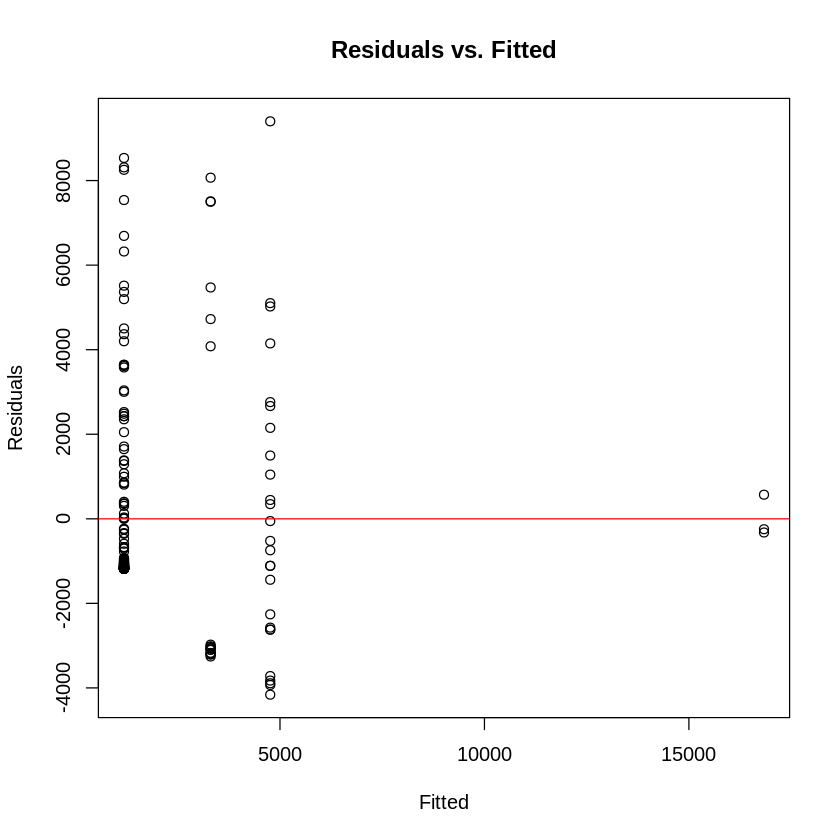

In [15]:
get_lm_assumptions(basic_did)

In [ ]:
#Modifications and Solutions:
#Correcting Standard Errors: Robust Standard Errors: Use heteroskedasticity and autocorrelation (HAC) robust standard errors. Tools like the Newey-West estimator in R can adjust the standard errors for autocorrelation and potential heteroskedasticity.
install.packages("sandwich")
library(sandwich)
library(lmtest)
coeftest(basic_did, vcov = NeweyWest(basic_did))

# Parallel trend assumptions (Basic DID model)

In [18]:
aggregated_df <- aggregated_df %>%
  mutate(year_factor = as.factor(year(ref_date)))  # Convert ref_date to year and then to a factor

# Fit the augmented DiD model
augmented_did <- lm(registrations ~ is_quebec * after_policy + is_quebec * year_factor, data = aggregated_df)

# Check the summary for insights into trend differences and policy impact
summary(augmented_did)

results = "The significance of the coefficients for the interaction terms between is_quebec and year_factor \n
prior to the policy implementation provides a formal test of the parallel trends. If these interaction terms \n
are not significantly different from zero, it supports the assumption that trends were parallel before the policy."
cat(results)


Call:
lm(formula = registrations ~ is_quebec * after_policy + is_quebec * 
    year_factor, data = aggregated_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3523.7 -1333.9  -555.0   794.6  7756.3 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                                 229.8      485.8   0.473 0.636713
is_quebecQuebec                             606.9     1285.4   0.472 0.637359
after_policyAfter Policy                    900.4      971.6   0.927 0.355294
year_factor2018                             331.1      687.1   0.482 0.630413
year_factor2019                             570.6      687.1   0.830 0.407341
year_factor2020                             633.3      687.1   0.922 0.357862
year_factor2021                            1181.0      687.1   1.719 0.087290
year_factor2022                            2252.0      687.1   3.278 0.001250
year_factor2023                            2485.4      841.5   2.954 0.003

The significance of the coefficients for the interaction terms between is_quebec and year_factor 

prior to the policy implementation provides a formal test of the parallel trends. If these interaction terms 

are not significantly different from zero, it supports the assumption that trends were parallel before the policy.

In [ ]:
# Event Study Approach
# Assuming `year_relative` is a factor variable for years relative to the treatment year (e.g., -2, -1, 0, 1, ...)
policy_year = 2023
aggregated_df$year_relative = as.factor(year(aggregated_df$ref_date) - policy_year)
str(aggregated_df)

table(aggregated_df$after_policy,aggregated_df$year_relative)
event_study <- lm(registrations ~ after_policy * year_relative, data = aggregated_df)
summary(event_study)

print("Perfect Collinearity:\nFor years -6 to -1, any interaction term involving 'After Policy' (like After Policy:year_relative-X) will be collinear because there is no variation—these years only ever occur 'Before Policy'.
\nThis lack of variability in the after_policy variable for these years is what leads to the NA coefficients in your model for these interaction terms.")

Things to do:

* check linear model assumptions and DID assumptions, make conclusions about assumptions
* add covariates
* introduce mixture

# DID model (mixed): modeling registrations by vehicle type and province

**Base model:** Registrations$_{i}$ = $\beta_0$+ $\beta_1$* Indicator(is quebec)+ $\beta_2$* Indicator(after policy in effect)+ $\beta_3$* Indicator(is quebec)* Indicator(after policy in effect) + $\beta_4 \cdot$ vehicle_type

**Mixed model:** Registrations$_{i}$ = $\beta_0$+ $\beta_1$* Indicator(is quebec)+ $\beta_2$* Indicator(after policy in effect)+ $\beta_3$* Indicator(is quebec)* Indicator(after policy in effect) + $\beta_4 \cdot$ vehicle_type


In [20]:
df_vehicle_type = df %>%
   filter(vehicle_type!="Total, vehicle type")

In [37]:
base_model <- lm(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type,
                    data = df_vehicle_type)

summary(base_model)


Call:
lm(formula = log(registrations + 1) ~ is_quebec * after_policy + 
    vehicle_type, data = df_vehicle_type)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1676 -0.8718 -0.2567  1.3277  5.6971 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                                3.8861     0.1497  25.954  < 2e-16
is_quebecQuebec                            1.9641     0.2179   9.014  < 2e-16
after_policyAfter Policy                   2.0637     0.2561   8.059 2.76e-15
vehicle_typePassenger cars                 0.2815     0.2042   1.378    0.168
vehicle_typePickup trucks                 -3.3066     0.2042 -16.193  < 2e-16
vehicle_typeVans                          -3.6295     0.2042 -17.774  < 2e-16
is_quebecQuebec:after_policyAfter Policy   1.0337     0.6775   1.526    0.127
                                            
(Intercept)                              ***
is_quebecQuebec                          ***
after_policyAfter

In [23]:
head(df_vehicle_type)
install.packages("lme4")

ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,Passenger cars,0,Non-Quebec,Before Policy,2017
2017-04-01,Prince Edward Island,Battery electric,Passenger cars,0,Non-Quebec,Before Policy,2017
2017-07-01,Prince Edward Island,Battery electric,Passenger cars,0,Non-Quebec,Before Policy,2017
2017-10-01,Prince Edward Island,Battery electric,Passenger cars,0,Non-Quebec,Before Policy,2017
2018-01-01,Prince Edward Island,Battery electric,Passenger cars,2,Non-Quebec,Before Policy,2018
2018-04-01,Prince Edward Island,Battery electric,Passenger cars,2,Non-Quebec,Before Policy,2018


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘RcppEigen’




In [38]:
library(lme4)

# Fit a mixed model with random intercepts for province and vehicle type
mixed_model <- lmer(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type + (1 | province) + (1 | vehicle_type),
                    data = df_vehicle_type)

summary(mixed_model)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


Linear mixed model fit by REML ['lmerMod']
Formula: log(registrations + 1) ~ is_quebec * after_policy + vehicle_type +  
    (1 | province) + (1 | vehicle_type)
   Data: df_vehicle_type

REML criterion at convergence: 3148.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0212 -0.9618  0.1407  0.7214  2.3547 

Random effects:
 Groups       Name        Variance Std.Dev.
 province     (Intercept)  2.081   1.443   
 vehicle_type (Intercept) 11.638   3.412   
 Residual                  2.733   1.653   
Number of obs: 812, groups:  province, 7; vehicle_type, 4

Fixed effects:
                                         Estimate Std. Error t value
(Intercept)                                3.8861     3.4641   1.122
is_quebecQuebec                            1.9641     1.5679   1.253
after_policyAfter Policy                   2.0637     0.2058  10.029
vehicle_typePassenger cars                 0.2815     4.8274   0.058
vehicle_typePickup trucks                 -3.3066     4.8274 

In [39]:
# Fit a mixed model with random intercepts for province
mixed_model_province <- lmer(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type + (1 | province),
                    data = df_vehicle_type)

summary(mixed_model_province)

Linear mixed model fit by REML ['lmerMod']
Formula: log(registrations + 1) ~ is_quebec * after_policy + vehicle_type +  
    (1 | province)
   Data: df_vehicle_type

REML criterion at convergence: 3148.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0212 -0.9618  0.1407  0.7214  2.3547 

Random effects:
 Groups   Name        Variance Std.Dev.
 province (Intercept) 2.081    1.442   
 Residual             2.733    1.653   
Number of obs: 812, groups:  province, 7

Fixed effects:
                                         Estimate Std. Error t value
(Intercept)                                3.8861     0.6011   6.465
is_quebecQuebec                            1.9641     1.5679   1.253
after_policyAfter Policy                   2.0637     0.2058  10.029
vehicle_typePassenger cars                 0.2815     0.1641   1.715
vehicle_typePickup trucks                 -3.3066     0.1641 -20.150
vehicle_typeVans                          -3.6295     0.1641 -22.118
is_quebecQuebec:a

In [40]:
# Fit a mixed model with random intercepts for province
log_mixed_model_province <- lmer(log(registrations+1) ~ is_quebec*after_policy +
                    vehicle_type + (1 | province),
                    data = df_vehicle_type)

summary(log_mixed_model_province)

Linear mixed model fit by REML ['lmerMod']
Formula: log(registrations + 1) ~ is_quebec * after_policy + vehicle_type +  
    (1 | province)
   Data: df_vehicle_type

REML criterion at convergence: 3148.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0212 -0.9618  0.1407  0.7214  2.3547 

Random effects:
 Groups   Name        Variance Std.Dev.
 province (Intercept) 2.081    1.442   
 Residual             2.733    1.653   
Number of obs: 812, groups:  province, 7

Fixed effects:
                                         Estimate Std. Error t value
(Intercept)                                3.8861     0.6011   6.465
is_quebecQuebec                            1.9641     1.5679   1.253
after_policyAfter Policy                   2.0637     0.2058  10.029
vehicle_typePassenger cars                 0.2815     0.1641   1.715
vehicle_typePickup trucks                 -3.3066     0.1641 -20.150
vehicle_typeVans                          -3.6295     0.1641 -22.118
is_quebecQuebec:a

In [41]:
# Fit a mixed model with random intercepts for vehicle type
mixed_model_vechicle_type <- lmer(log(registrations+1) ~  is_quebec*after_policy +
                    vehicle_type + (1 | vehicle_type),
                    data = df_vehicle_type)

summary(mixed_model_vechicle_type)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML ['lmerMod']
Formula: log(registrations + 1) ~ is_quebec * after_policy + vehicle_type +  
    (1 | vehicle_type)
   Data: df_vehicle_type

REML criterion at convergence: 3478.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0258 -0.4237 -0.1248  0.6454  2.7692 

Random effects:
 Groups       Name        Variance Std.Dev.
 vehicle_type (Intercept) 0.000    0.000   
 Residual                 4.232    2.057   
Number of obs: 812, groups:  vehicle_type, 4

Fixed effects:
                                         Estimate Std. Error t value
(Intercept)                                3.8861     0.1497  25.954
is_quebecQuebec                            1.9641     0.2179   9.014
after_policyAfter Policy                   2.0637     0.2561   8.059
vehicle_typePassenger cars                 0.2815     0.2042   1.378
vehicle_typePickup trucks                 -3.3066     0.2042 -16.193
vehicle_typeVans                          -3.6295     0.2042 -17.7

In [42]:
# Fit a mixed model with random intercepts for vehicle type
mixed_model_vechicle_type_province <- lmer(log(registrations+1) ~  is_quebec*after_policy +
                    vehicle_type + (1 | vehicle_type:province),
                    data = df_vehicle_type)

summary(mixed_model_vechicle_type_province)

Linear mixed model fit by REML ['lmerMod']
Formula: log(registrations + 1) ~ is_quebec * after_policy + vehicle_type +  
    (1 | vehicle_type:province)
   Data: df_vehicle_type

REML criterion at convergence: 2907.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9883 -0.7595 -0.1999  0.5332  3.6328 

Random effects:
 Groups                Name        Variance Std.Dev.
 vehicle_type:province (Intercept) 2.855    1.690   
 Residual                          1.867    1.366   
Number of obs: 812, groups:  vehicle_type:province, 28

Fixed effects:
                                         Estimate Std. Error t value
(Intercept)                                3.8861     0.6594   5.894
is_quebecQuebec                            1.9641     0.9239   2.126
after_policyAfter Policy                   2.0637     0.1701  12.135
vehicle_typePassenger cars                 0.2815     0.9133   0.308
vehicle_typePickup trucks                 -3.3066     0.9133  -3.620
vehicle_typeVans    

In [43]:
# Compare models
AIC(base_model, mixed_model_vechicle_type_province)
AIC(base_model, mixed_model_province)
AIC(base_model, mixed_model_vechicle_type)

,df,AIC
,<dbl>,<dbl>
base_model,8,3484.849
mixed_model_vechicle_type_province,9,2925.106


,df,AIC
,<dbl>,<dbl>
base_model,8,3484.849
mixed_model_province,9,3166.743


,df,AIC
,<dbl>,<dbl>
base_model,8,3484.849
mixed_model_vechicle_type,9,3496.310


In [ ]:
install.packages("lmtest")
library(lmtest)
bptest(mixed_model_province)  # Breusch-Pagan test on the original model
bptest(log_mixed_model_province)  # On the log-transformed model

[1] "\nQQ plot of residuals: basic_did"
[1] "\nQQ plot of residuals: mixed_model_province"


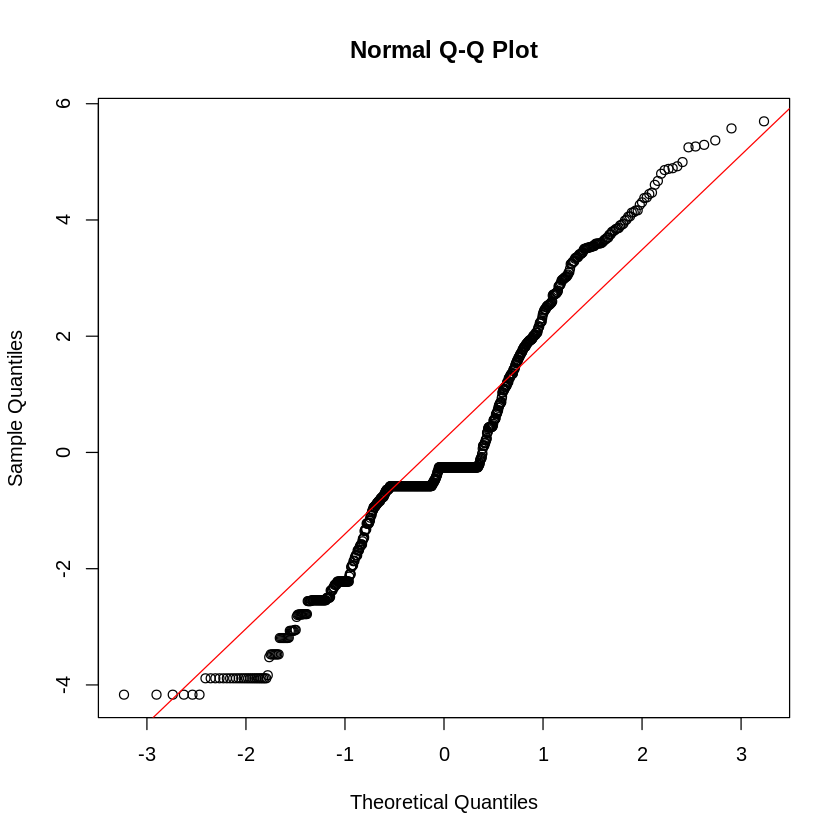

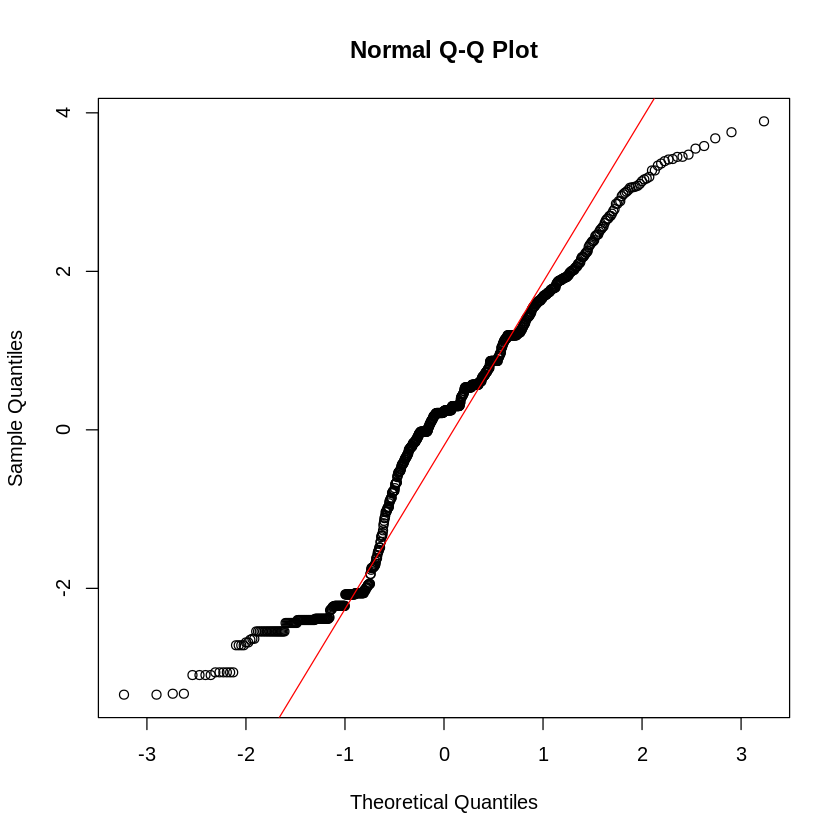

In [44]:
  print("\nQQ plot of residuals: basic_did")
  qqnorm(residuals(base_model))
  qqline(residuals(base_model), col = "red") #normal should look like this

  print("\nQQ plot of residuals: mixed_model_province")
  qqnorm(residuals(mixed_model_province))
  qqline(residuals(mixed_model_province), col = "red") #normal should look like this


[1] "\nQQ plot of residuals: log_basic_did"
[1] "\nQQ plot of residuals: log_mixed_model_province"


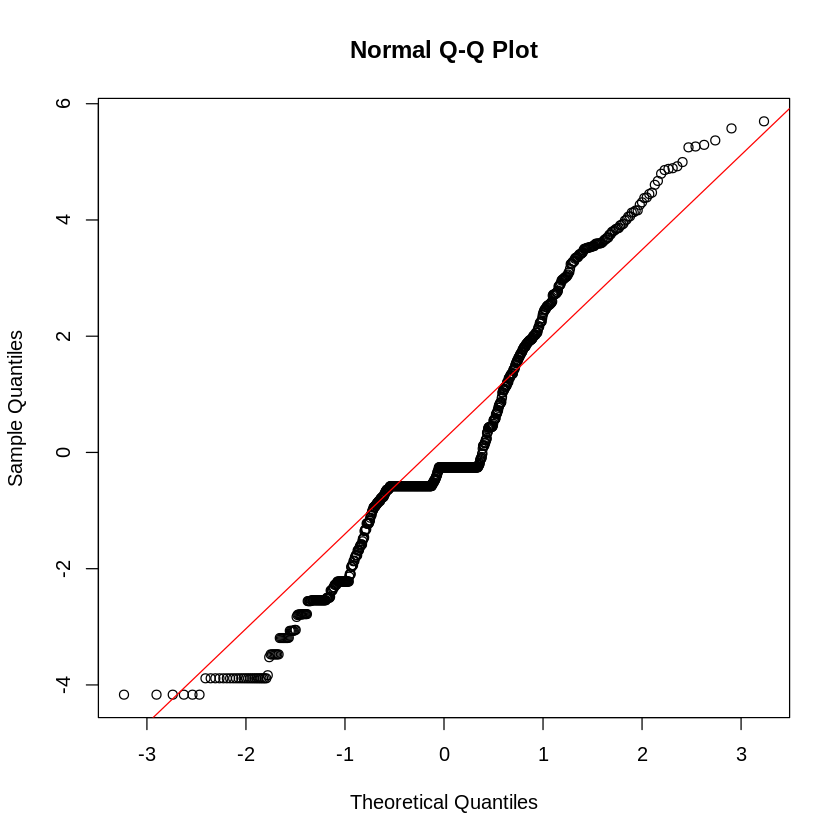

[1] "\nQQ plot of residuals: mixed_model_vechicle_type"


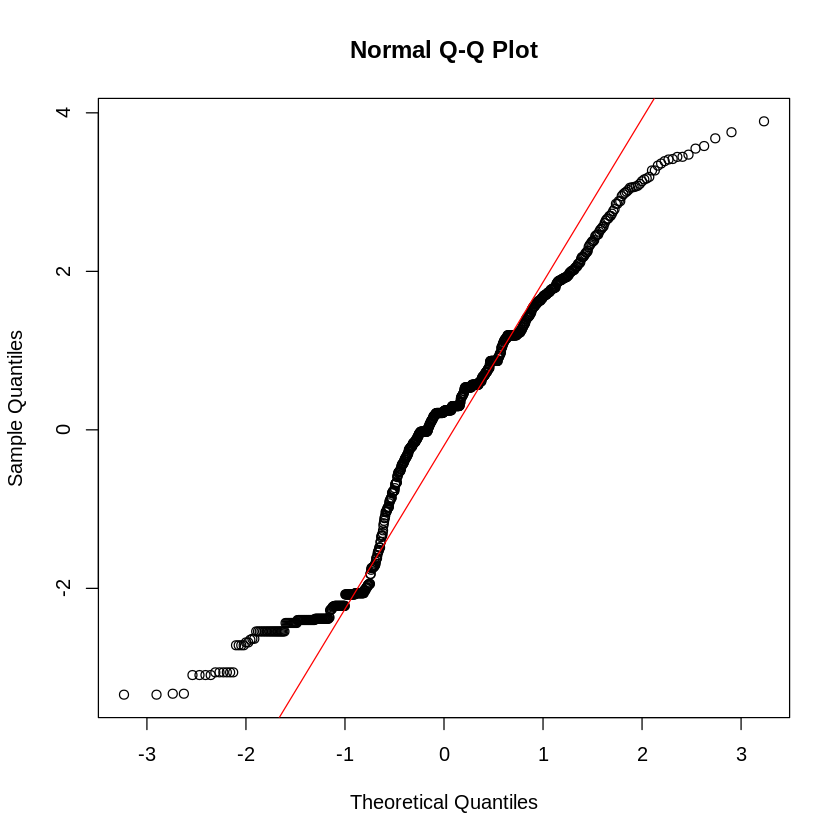

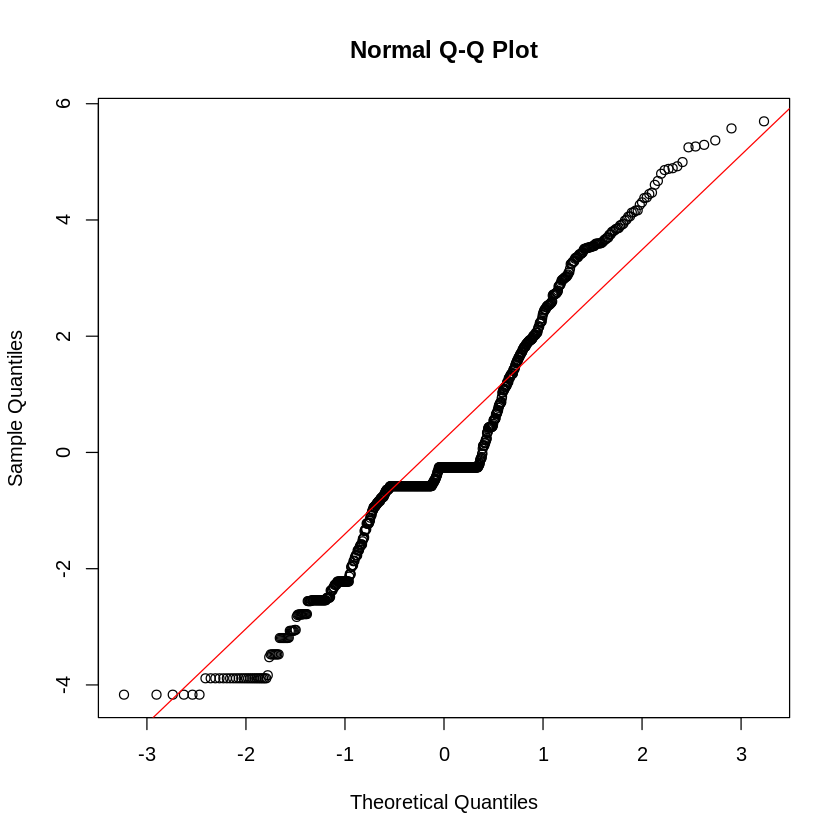

In [45]:

  print("\nQQ plot of residuals: log_basic_did")
  qqnorm(residuals(base_model))
  qqline(residuals(base_model), col = "red") #normal should look like this

  print("\nQQ plot of residuals: log_mixed_model_province")
  qqnorm(residuals(log_mixed_model_province))
  qqline(residuals(log_mixed_model_province), col = "red") #normal should look like this

  print("\nQQ plot of residuals: mixed_model_vechicle_type")
  qqnorm(residuals(mixed_model_vechicle_type))
  qqline(residuals(mixed_model_vechicle_type), col = "red") #normal should look like this


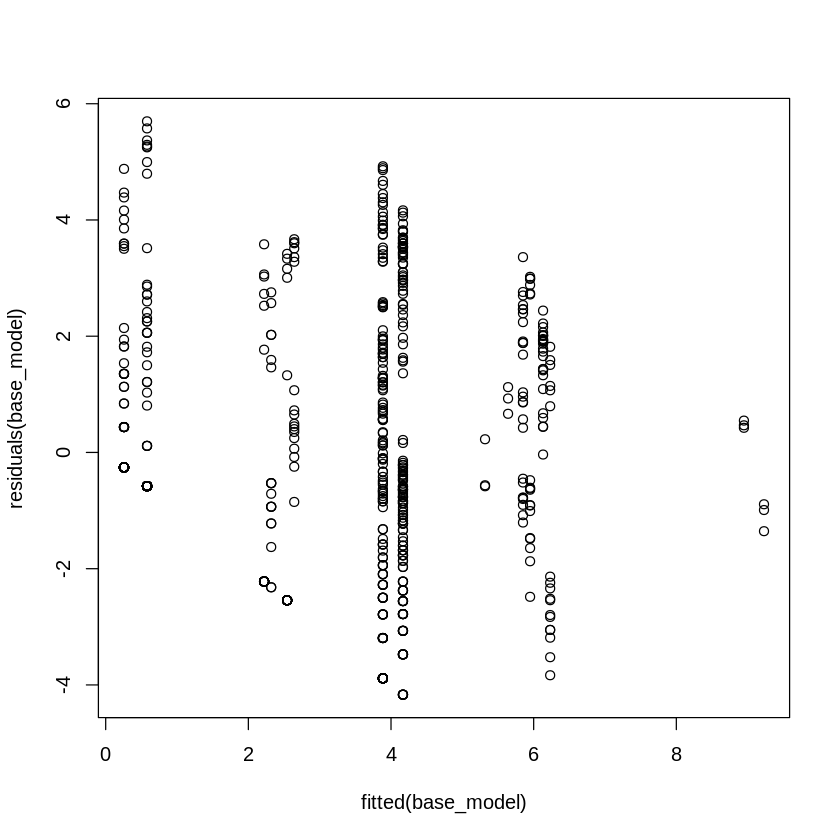

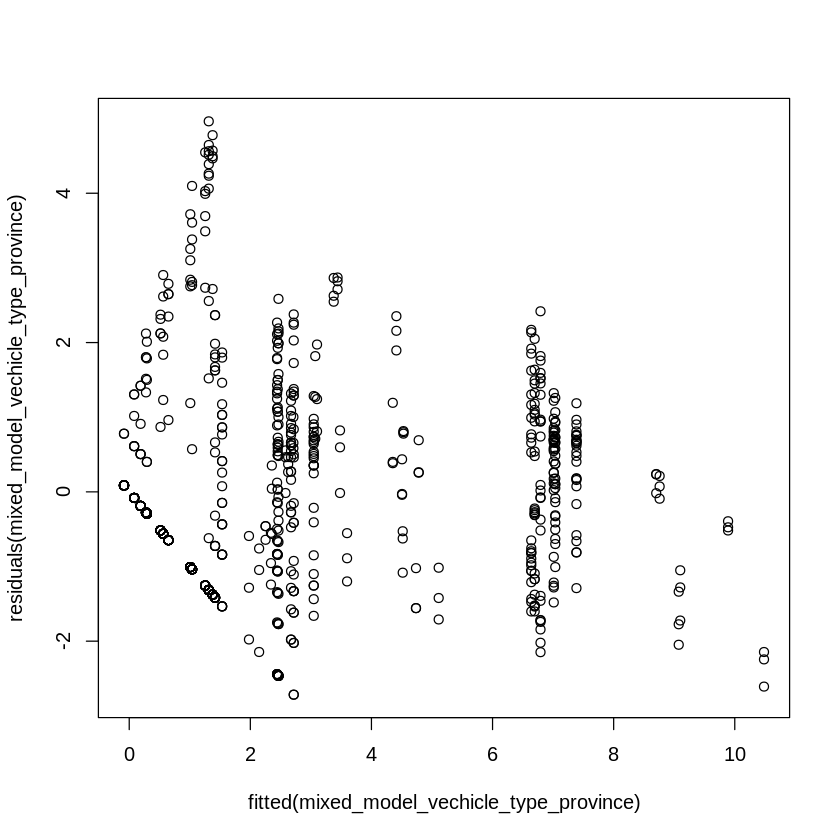

In [47]:
plot(residuals(base_model) ~ fitted(base_model))
plot(residuals(mixed_model_vechicle_type_province) ~ fitted(mixed_model_vechicle_type_province))

In [48]:
library(lme4)
# Example using bootMer to perform a parametric bootstrap
set.seed(123)
cv_model1 <- bootMer(mixed_model_vechicle_type_province, FUN = function(x) fixef(x), nsim = 100)
cv_model2 <- bootMer(mixed_model_province, FUN = function(x) fixef(x), nsim = 100)
cv_model3 <- bootMer(mixed_model, FUN = function(x) fixef(x), nsim = 100)
cv_model4 <- bootMer(mixed_model_vechicle_type, FUN = function(x) fixef(x), nsim = 100)

cv_model1
cv_model2
cv_model3
cv_model4


PARAMETRIC BOOTSTRAP


Call:
bootMer(x = mixed_model_vechicle_type_province, FUN = function(x) fixef(x), 
    nsim = 100)


Bootstrap Statistics :
      original      bias    std. error
t1*  3.8861117  0.04913040   0.6528484
t2*  1.9641228  0.12611246   0.8604994
t3*  2.0636617  0.01254279   0.1726836
t4*  0.2814809 -0.09128359   0.8666753
t5* -3.3065735 -0.07133367   0.9365427
t6* -3.6294503 -0.03681776   0.8871324
t7*  1.0337431 -0.03309329   0.4493028


PARAMETRIC BOOTSTRAP


Call:
bootMer(x = mixed_model_province, FUN = function(x) fixef(x), 
    nsim = 100)


Bootstrap Statistics :
      original       bias    std. error
t1*  3.8861117 -0.022088231   0.5840091
t2*  1.9641228 -0.177048558   1.4441080
t3*  2.0636617 -0.041550943   0.1872029
t4*  0.2814809 -0.013898010   0.1524688
t5* -3.3065735  0.012092321   0.1661185
t6* -3.6294503  0.002553335   0.1865571
t7*  1.0337431  0.036016683   0.5543753


1 message(s): boundary (singular) fit: see help('isSingular')
119 warning(s): Model failed to converge with max|grad| = 0.0284041 (tol = 0.002, component 1) (and others)





PARAMETRIC BOOTSTRAP


Call:
bootMer(x = mixed_model, FUN = function(x) fixef(x), nsim = 100)


Bootstrap Statistics :
      original       bias    std. error
t1*  3.8861117 -0.449724071   3.6289515
t2*  1.9641228 -0.284501298   1.5152913
t3*  2.0636617 -0.007975772   0.2090271
t4*  0.2814809  0.008851934   4.4827390
t5* -3.3065735  0.858857049   5.2166035
t6* -3.6294503  0.278225978   5.4992275
t7*  1.0337431  0.059586572   0.5386371


86 message(s): boundary (singular) fit: see help('isSingular')
2 warning(s): Model failed to converge: degenerate  Hessian with 1 negative eigenvalues (and others)





PARAMETRIC BOOTSTRAP


Call:
bootMer(x = mixed_model_vechicle_type, FUN = function(x) fixef(x), 
    nsim = 100)


Bootstrap Statistics :
      original       bias    std. error
t1*  3.8861117 -0.000288245   0.1365964
t2*  1.9641228  0.006301537   0.2270740
t3*  2.0636617  0.004581953   0.2753401
t4*  0.2814809 -0.005442188   0.1887228
t5* -3.3065735 -0.007194671   0.1970434
t6* -3.6294503 -0.033891665   0.1987390
t7*  1.0337431  0.066019712   0.6917551